In [1]:
from utils import *

import folium
import geopandas as gpd

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_log_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from xgboost import XGBRegressor

## Data description

In [2]:
macro_df = pd.read_csv('data/macro.csv', parse_dates=['timestamp'])
train_df = pd.read_csv('data/train.csv', index_col='id', parse_dates=['timestamp'])
test_df = pd.read_csv('data/test.csv', index_col='id', parse_dates=['timestamp'])
tverskoe_issue_fix(train_df)
tverskoe_issue_fix(test_df)

Fix:  550
Fix:  149


## 1. Data preprocessing
## I part (encoding and correcting mistakes)

### Macro dataset

In [3]:
macro_df['child_on_acc_pre_school'] = macro_df['child_on_acc_pre_school'].str.replace('#!', 'nan')
for column in macro_df.select_dtypes('object').columns:
    macro_df[column] = macro_df[column].str.replace(',', '.')
    macro_df[column] = macro_df[column].astype(float)

if not len(macro_df.select_dtypes('object').columns):
    print('OK')

OK


### Train dataset

In [4]:
train_df = encode(train_df)

### Test dataset

In [5]:
test_df = encode(test_df)

## II part (Filling missing values)

XGBRegressor model handles `np.NaN` values itself

## 2. Encoding `sub_area` feature

In [6]:
train_df['is_train'] = 1
test_df['is_train'] = 0

coords_df = pd.read_csv('data/coords.csv', index_col='id')
all_df = pd.concat([train_df, test_df])

all_df['latitude'] = coords_df['latitude']
all_df['longitude'] = coords_df['longitude']

## 3. Removing outliers

In [7]:
all_df = remove_outliers(all_df)

In [8]:
train_df = all_df[all_df['is_train'] == 1].drop(['is_train'], axis=1)
test_df = all_df[all_df['is_train'] == 0].drop(['is_train', 'price_doc'], axis=1)

In [9]:
idx_outliers = np.loadtxt('data/idx_outliers.txt').astype(int)
len(idx_outliers)

2695

### `product_type == 'Investment'`

In [10]:
X = train_df.drop(idx_outliers).copy()

In [11]:
train_df_0 = X[X['product_type'] == 0]

X = train_df_0.drop(['sub_area', 'price_doc'], axis=1).copy()
y = np.log1p(train_df_0['price_doc'])

In [12]:
y_pred_val = []
y_pred_train = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_splits = kf.split(X)

params = {'objective': 'reg:squarederror',
          'n_estimators': 10000,
          'tree_method': 'gpu_hist',
          'booster': 'gbtree',
          'base_score': 7,
          'learning_rate': 0.05,
          'max_depth': 4,
          'min_child_weight': 7,
          'subsample': 1,
          'colsample_bytree': 0.9,
          'reg_lambda': 5,
          'reg_alpha': 1,
          'eval_metric': 'rmse',
          'seed': 42,
          'nthread': -1
          }

for train_index, val_index in kf_splits:
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    model = XGBRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], early_stopping_rounds=50)
    y_pred_train.append(model.predict(X_train))
    y_pred_val.append(model.predict(X_val))

[0]	validation_0-rmse:8.40691	validation_1-rmse:8.40127
[1]	validation_0-rmse:7.98749	validation_1-rmse:7.98199
[2]	validation_0-rmse:7.58909	validation_1-rmse:7.58361
[3]	validation_0-rmse:7.21059	validation_1-rmse:7.20526
[4]	validation_0-rmse:6.85103	validation_1-rmse:6.84587
[5]	validation_0-rmse:6.50950	validation_1-rmse:6.50437
[6]	validation_0-rmse:6.18502	validation_1-rmse:6.18003
[7]	validation_0-rmse:5.87678	validation_1-rmse:5.87197
[8]	validation_0-rmse:5.58399	validation_1-rmse:5.57927
[9]	validation_0-rmse:5.30584	validation_1-rmse:5.30129
[10]	validation_0-rmse:5.04163	validation_1-rmse:5.03727
[11]	validation_0-rmse:4.79065	validation_1-rmse:4.78633
[12]	validation_0-rmse:4.55224	validation_1-rmse:4.54812
[13]	validation_0-rmse:4.32576	validation_1-rmse:4.32181
[14]	validation_0-rmse:4.11062	validation_1-rmse:4.10693
[15]	validation_0-rmse:3.90630	validation_1-rmse:3.90286
[16]	validation_0-rmse:3.71218	validation_1-rmse:3.70880
[17]	validation_0-rmse:3.52776	validation

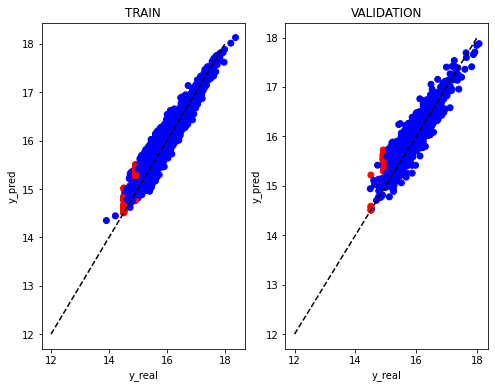

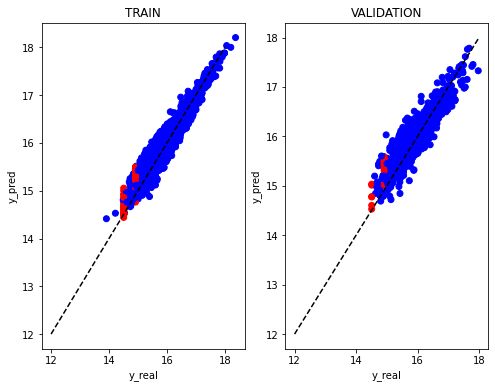

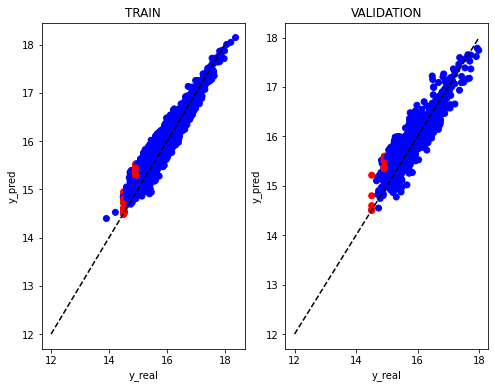

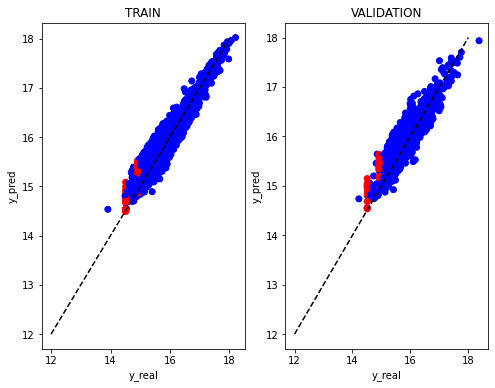

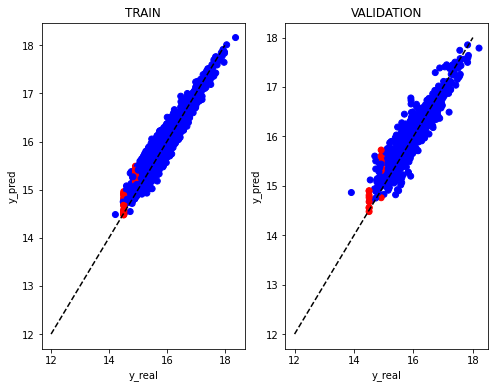

In [13]:
train_errors = []
val_errors = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_splits = kf.split(X)

for i, (train_index, val_index) in enumerate(kf_splits):
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    # train_errors.append(np.abs(y_pred_train[i] - y_train) / np.abs(y_train))
    # val_errors.append(np.abs(y_pred_val[i] - y_val) / np.abs(y_val))
    train_errors.append(np.square(y_pred_train[i] - y_train))
    val_errors.append(np.square(y_pred_val[i] - y_val))


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))

    mask_fake_prices = (y_train == np.log1p(1_000_000)) | \
                       (y_train == np.log1p(2_000_000)) | \
                       (y_train == np.log1p(3_000_000))
    ax1.scatter(y_train, y_pred_train[i], cmap='bwr', c=mask_fake_prices)
    ax1.plot(np.linspace(12, 18, 100), np.linspace(12, 18, 100), c='black', linestyle='--')
    ax1.set_title('TRAIN')
    ax1.set_xlabel('y_real')
    ax1.set_ylabel('y_pred')

    mask_fake_prices = (y_val == np.log1p(1_000_000)) | \
                       (y_val == np.log1p(2_000_000)) | \
                       (y_val == np.log1p(3_000_000))
    ax2.scatter(y_val, y_pred_val[i], cmap='bwr', c=mask_fake_prices)
    ax2.plot(np.linspace(12, 18, 100), np.linspace(12, 18, 100), c='black', linestyle='--')
    ax2.set_title('VALIDATION')
    ax2.set_xlabel('y_real')
    ax2.set_ylabel('y_pred')

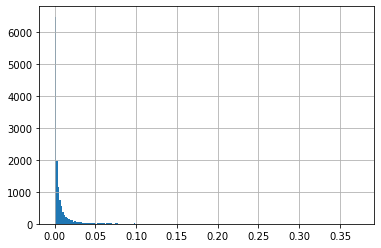

In [14]:
train_errors[4].hist(bins=200);

In [42]:
idx_outliers = []

for train_error in train_errors:
    idx_outliers.append(train_error[train_error > 0.4].index.values)

for val_error in val_errors:
    idx_outliers.append(val_error[val_error > 0.4].index.values)

idx_outliers = np.concatenate(idx_outliers)
idx_outliers = np.unique(idx_outliers)

In [16]:
idx_outliers_old = np.loadtxt('data/idx_outliers_1.txt').astype(int)

In [17]:
len(idx_outliers_old)

1997

In [45]:
idx_outliers = np.append(idx_outliers, idx_outliers_old)

In [19]:
len(idx_outliers)

2695

In [18]:
np.savetxt('data/idx_outliers.txt', idx_outliers, fmt='%d')

### `product_type == 'Investment'`

In [20]:
X = train_df.drop(idx_outliers).copy()

In [21]:
train_df_1 = X[X['product_type'] == 1]

X = train_df_1.drop(['sub_area', 'price_doc'], axis=1).copy()
y = np.log1p(train_df_1['price_doc'])

In [22]:
y_pred_val = []
y_pred_train = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_splits = kf.split(X)

params = {'objective': 'reg:squarederror',
          'n_estimators': 10000,
          'tree_method': 'gpu_hist',
          'booster': 'gbtree',
          'base_score': 7,
          'learning_rate': 0.05,
          'max_depth': 4,
          'min_child_weight': 7,
          'subsample': 1,
          'colsample_bytree': 0.9,
          'reg_lambda': 5,
          'reg_alpha': 1,
          'eval_metric': 'rmse',
          'seed': 42,
          'nthread': -1
          }

for train_index, val_index in kf_splits:
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    model = XGBRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], early_stopping_rounds=50)
    y_pred_train.append(model.predict(X_train))
    y_pred_val.append(model.predict(X_val))

[0]	validation_0-rmse:8.14738	validation_1-rmse:8.15217
[1]	validation_0-rmse:7.74130	validation_1-rmse:7.74549
[2]	validation_0-rmse:7.35554	validation_1-rmse:7.35916
[3]	validation_0-rmse:6.98904	validation_1-rmse:6.99283
[4]	validation_0-rmse:6.64085	validation_1-rmse:6.64457
[5]	validation_0-rmse:6.31011	validation_1-rmse:6.31330
[6]	validation_0-rmse:5.99586	validation_1-rmse:5.99894
[7]	validation_0-rmse:5.69735	validation_1-rmse:5.70054
[8]	validation_0-rmse:5.41373	validation_1-rmse:5.41692
[9]	validation_0-rmse:5.14430	validation_1-rmse:5.14735
[10]	validation_0-rmse:4.88835	validation_1-rmse:4.89140
[11]	validation_0-rmse:4.64517	validation_1-rmse:4.64783
[12]	validation_0-rmse:4.41419	validation_1-rmse:4.41683
[13]	validation_0-rmse:4.19473	validation_1-rmse:4.19704
[14]	validation_0-rmse:3.98626	validation_1-rmse:3.98834
[15]	validation_0-rmse:3.78822	validation_1-rmse:3.79004
[16]	validation_0-rmse:3.60006	validation_1-rmse:3.60174
[17]	validation_0-rmse:3.42133	validation

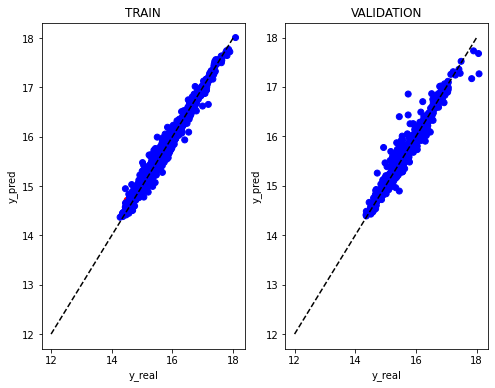

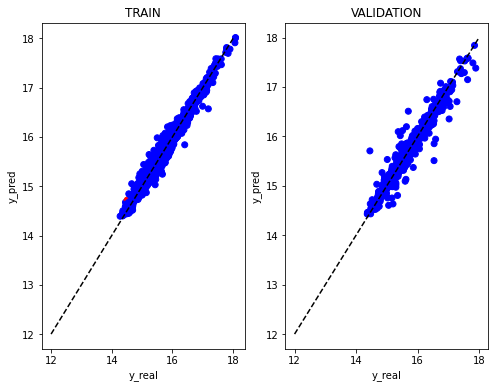

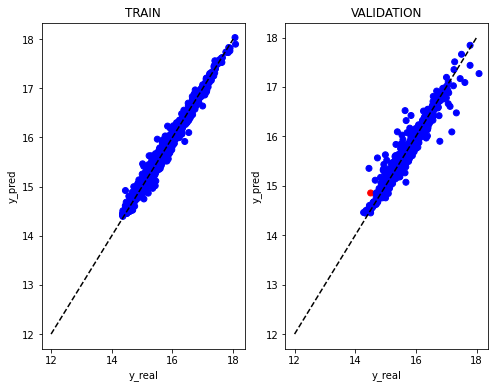

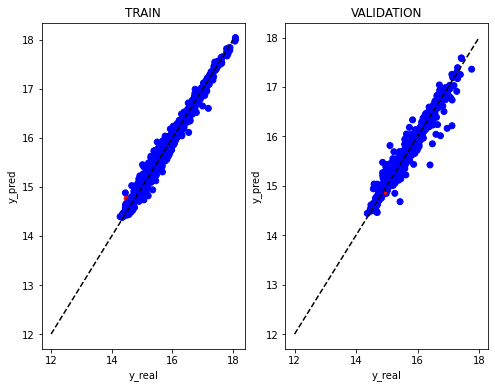

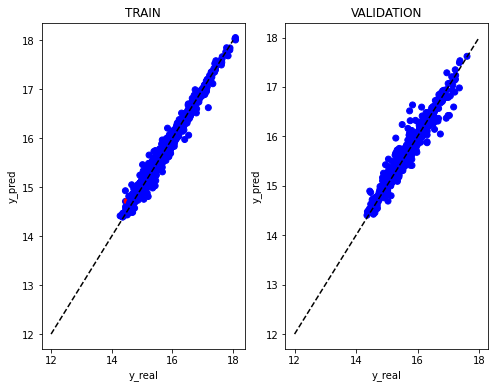

In [23]:
train_errors = []
val_errors = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_splits = kf.split(X)

for i, (train_index, val_index) in enumerate(kf_splits):
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    # train_errors.append(np.abs(y_pred_train[i] - y_train) / np.abs(y_train))
    # val_errors.append(np.abs(y_pred_val[i] - y_val) / np.abs(y_val))
    train_errors.append(np.square(y_pred_train[i] - y_train))
    val_errors.append(np.square(y_pred_val[i] - y_val))


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))

    mask_fake_prices = (y_train == np.log1p(1_000_000)) | \
                       (y_train == np.log1p(2_000_000)) | \
                       (y_train == np.log1p(3_000_000))
    ax1.scatter(y_train, y_pred_train[i], cmap='bwr', c=mask_fake_prices)
    ax1.plot(np.linspace(12, 18, 100), np.linspace(12, 18, 100), c='black', linestyle='--')
    ax1.set_title('TRAIN')
    ax1.set_xlabel('y_real')
    ax1.set_ylabel('y_pred')

    mask_fake_prices = (y_val == np.log1p(1_000_000)) | \
                       (y_val == np.log1p(2_000_000)) | \
                       (y_val == np.log1p(3_000_000))
    ax2.scatter(y_val, y_pred_val[i], cmap='bwr', c=mask_fake_prices)
    ax2.plot(np.linspace(12, 18, 100), np.linspace(12, 18, 100), c='black', linestyle='--')
    ax2.set_title('VALIDATION')
    ax2.set_xlabel('y_real')
    ax2.set_ylabel('y_pred')

In [158]:
np.savetxt('data/idx_outliers.txt', idx_outliers_full, fmt='%d')

### `product_type == 'OwnerOccupier'`

In [107]:
train_df_1 = train_df[train_df['product_type'] == 1]
test_df_1 = test_df[test_df['product_type'] == 1]

X_1 = train_df_1.drop(['sub_area', 'price_doc'], axis=1).copy()
y_1 = np.log1p(train_df_1['price_doc'])
X_test_1 = test_df_1.drop(['sub_area'], axis=1).copy()

In [ ]:
y_pred_val = []
y_pred_train = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_splits = kf.split(X_1)

params = {'objective': 'reg:squarederror',
          'n_estimators': 10000,
          'tree_method': 'gpu_hist',
          'booster': 'gbtree',
          'base_score': 7,
          'learning_rate': 0.05,
          'max_depth': 4,
          'min_child_weight': 7,
          'subsample': 1,
          'colsample_bytree': 0.9,
          'reg_lambda': 5,
          'reg_alpha': 1,
          'eval_metric': 'rmse',
          'seed': 42,
          'nthread': -1
          }

for train_index, val_index in kf_splits:
    X_train, X_val = X_1.iloc[train_index], X_1.iloc[val_index]
    y_train, y_val = y_1.iloc[train_index], y_1.iloc[val_index]
    model = XGBRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], early_stopping_rounds=50)
    y_pred_train.append(model.predict(X_train))
    y_pred_val.append(model.predict(X_val))

In [ ]:
train_errors = []
val_errors = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf_splits = kf.split(X_1)

for i, (train_index, val_index) in enumerate(kf_splits):
    y_train, y_val = y_1.iloc[train_index], y_1.iloc[val_index]
    # train_errors.append(np.abs(y_pred_train[i] - y_train) / np.abs(y_train))
    # val_errors.append(np.abs(y_pred_val[i] - y_val) / np.abs(y_val))
    train_errors.append(np.square(y_pred_train[i] - y_train))
    val_errors.append(np.square(y_pred_val[i] - y_val))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))

    mask_fake_prices = (y_train == np.log1p(1_000_000)) | \
                       (y_train == np.log1p(2_000_000)) | \
                       (y_train == np.log1p(3_000_000))
    ax1.scatter(y_train, y_pred_train[i], cmap='bwr', c=mask_fake_prices)
    ax1.plot(np.linspace(12, 18, 100), np.linspace(12, 18, 100), c='black', linestyle='--')
    ax1.set_title('TRAIN')
    ax1.set_xlabel('y_real')
    ax1.set_ylabel('y_pred')

    mask_fake_prices = (y_val == np.log1p(1_000_000)) | \
                       (y_val == np.log1p(2_000_000)) | \
                       (y_val == np.log1p(3_000_000))
    ax2.scatter(y_val, y_pred_val[i], cmap='bwr', c=mask_fake_prices)
    ax2.plot(np.linspace(12, 18, 100), np.linspace(12, 18, 100), c='black', linestyle='--')
    ax2.set_title('VALIDATION')
    ax2.set_xlabel('y_real')
    ax2.set_ylabel('y_pred')

In [ ]:
train_errors[0].hist(bins=200)